# Pairwise Order relation

## Set Up

In [1]:
import sys
sys.path.append('../..'); sys.path.append('../'); 

import numpy as np
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import tensorflow as tf

import itertools

import utils

from tqdm import tqdm, trange


In [2]:
import sys
sys.path.append('../..'); sys.path.append('../');

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
import utils

In [23]:
tf.__version__

'2.13.1'

## Object Dataset

In [3]:
# create data set for learning order relatios
num_objects = 32
object_dim = 64
object_pairs = np.array(list(itertools.permutations(range(num_objects), r=2)))
object_order_relations = (object_pairs[:,0] < object_pairs[:, 1]).astype(int)
sample = np.random.choice(len(object_pairs), 10)
for object_pair, relation in zip(object_pairs[sample], object_order_relations[sample]):
    print(f'object pair: {tuple(object_pair)}; relation: {relation}')

object pair: (29, 15); relation: 0
object pair: (0, 10); relation: 1
object pair: (6, 29); relation: 1
object pair: (2, 18); relation: 1
object pair: (7, 5); relation: 0
object pair: (22, 0); relation: 0
object pair: (17, 28); relation: 1
object pair: (24, 14); relation: 0
object pair: (4, 17); relation: 1
object pair: (27, 7); relation: 0


In [4]:
objects = np.random.normal(loc=0., scale=1., size=(num_objects, object_dim))

X = objects[object_pairs]
y = object_order_relations

In [5]:
X.shape, y.shape, y.mean()

((992, 2, 64), (992,), 0.5)

In [6]:
from sklearn.model_selection import train_test_split
test_size = 0.35
val_size = 0.15
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size/(1-test_size))

In [28]:
len(y_train), len(y_val), len(y_test)

(495, 149, 348)

In [7]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='binary_crossentropy')
create_opt = lambda : tf.keras.optimizers.Adam(learning_rate=0.001)

In [45]:
embedding_dim = 64
D = 1000
import tensorflow.keras.backend as K
encoder_kwargs=dict(use_bias=True)
ordertransformer_kwargs = dict(embedding_dim=embedding_dim, encoder_kwargs=encoder_kwargs)
class BipolarDenseLayer(layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super(BipolarDenseLayer, self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer="glorot_uniform",
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer="zeros",
                                 trainable=True)

    def call(self, inputs, training=False):
        if training:
            weights = tf.math.sign(self.w)
        else:
            weights = tf.math.sign(self.w)
            #weights = self.w
        output = tf.matmul(inputs, weights) + self.b
        if self.activation is not None:
            output = self.activation(output)
        return output


class HDSymbolicAttention(Layer):
    def __init__(self, d_model,dim, **kwargs):
        super(HDSymbolicAttention, self).__init__(**kwargs)
        self.d_model = d_model  # Dimensionality of the model
        self.dim = dim
    

    def cosine_similarity(self, a, b):
        # Compute the cosine similarity as dot product divided by magnitudes
        dot_product = tf.reduce_sum(tf.math.sign(a) * tf.math.sign(b), axis=-1)/1000
        return dot_product   
    
    
    def create_cosine_similarity_matrix(self,X):
        X_expanded = tf.expand_dims(X, 2)  # Shape: (batch_size, N, 1, D)
        X_repeated = tf.repeat(X_expanded, repeats=tf.shape(X)[1], axis=2)  # Shape: (batch_size, N, N, D)
    
        X_i_expanded = tf.expand_dims(X, 1)  # Shape: (batch_size, 1, N, D)
        X_i_repeated = tf.repeat(X_i_expanded, repeats=tf.shape(X)[1], axis=1)  # Shape: (batch_size, N, N, D)
    
        X_i_plus_X_j =  X_repeated + X_i_repeated   # Broadcasting adds the matrices element-wise
        S = self.cosine_similarity(X_i_repeated, X_i_plus_X_j)  # Shape: (batch_size, N, N)
        return tf.nn.softmax(S)
            
    def build(self, input_shape):
        
                                                                         
        normal_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
        self.Symbols = tf.Variable(
                normal_initializer(shape=(2, 64)),
                name='symbols', trainable=True)          
        self.dropout= layers.Dropout(0.05)
        self.dense_layers = [BipolarDenseLayer(self.d_model, activation='tanh') for _ in range(self.dim)]
        self.bn1 = layers.BatchNormalization(synchronized=True)
        super(HDSymbolicAttention, self).build(input_shape)
    def call(self, values):
    
        # Unpack the inputs (queries, keys, values)
        self.S3 = tf.zeros_like(values)
        self.S3 = self.S3 + self.Symbols 
        h_vectors = [self.dense_layers[i](values[:, i, :]) for i in range(len(self.dense_layers))]
        h_vectors2 = [self.dense_layers[i](self.S3[:, i, :]) for i in range(len(self.dense_layers))]
        values_projected = tf.stack(h_vectors, axis=1)
        symbol_projected = tf.stack(h_vectors2, axis=1)
        scores  = self.create_cosine_similarity_matrix(values_projected)
        attention_output = tf.einsum('bij,bkk->bkj', values_projected, scores) 
        return  tf.nn.swish(attention_output * symbol_projected)    
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], input_shape[0][1], self.d_model)

class LARS_VSA(tf.keras.Model):
    def __init__(self, embedding_dim, encoder_kwargs, name=None):
        super().__init__(name=name)
        #self.embedder = layers.Dense(embedding_dim)
        object_embedder = tf.keras.Sequential([layers.Dense(embedding_dim)])
        self.source_embedder = layers.TimeDistributed(object_embedder, name='source_embedder')
        self.dropout = layers.Dropout(0.1)
        self.flatten = layers.Flatten()
        self.hidden_dense = layers.Dense(32, activation='relu', name='hidden_layer')
        self.final_layer = layers.Dense(1, activation='sigmoid', name='final_layer')
        self.mha = HDSymbolicAttention(1000,2) 
        self.bn = layers.BatchNormalization(synchronized=True) 
    def call(self, inputs):
        #x = self.embedder(inputs)
        x = self.source_embedder(inputs)
        h0 = self.mha(x)
        h0 = self.dropout(h0)
        x = self.flatten(h0)
        x = self.hidden_dense(x)
        x = self.final_layer(x)

        return x

    def print_summary(self, input_shape):
        inputs = layers.Input(input_shape)
        outputs = self.call(inputs)
        print(tf.keras.Model(inputs, outputs, name=self.name).summary())


transformer_model = LARS_VSA(**ordertransformer_kwargs, name='rmts_transformer')
transformer_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])

Model: "rmts_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 2, 64)]           0         
                                                                 
 source_embedder (TimeDistr  (None, 2, 64)             4160      
 ibuted)                                                         
                                                                 
 simplified_multi_head_atte  (None, 2, 1000)           130128    
 ntion_194 (SimplifiedMulti                                      
 HeadAttention)                                                  
                                                                 
 dropout_308 (Dropout)       (None, 2, 1000)           0         
                                                                 
 flatten_194 (Flatten)       (None, 2000)              0         
                                                  

In [46]:
Total_hdc = []
for train_size in [10,50,75,100,150,175,200,500,1000,2000]:
    hdc = []
    for j in range(10):
        np.random.seed(j)
        create_opt = lambda : tf.keras.optimizers.Adam(learning_rate=0.0001)
        transformer_model = LARS_VSA(**ordertransformer_kwargs, name='rmts_transformer')
        transformer_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
        X_train_1, y_train_1 = X_train[:train_size], y_train[:train_size]
        history = transformer_model.fit(X_train_1, y_train_1, validation_data=(X_val, y_val), epochs=50, batch_size=64,verbose=0)
        acc = transformer_model.evaluate(X_test, y_test,verbose=0)[1]
        hdc.append(acc)
    hdc = np.array(hdc)
    Total_hdc.append(hdc)

In [33]:
from tensorflow.keras import layers
from baseline_models.predinet import PrediNet
embedding_dim = 64
predinet_kwargs = dict(embedding_dim=embedding_dim, predinet_kwargs=dict(key_dim=4, n_heads=4, n_relations=16, add_temp_tag=False))

def create_predinet(embedding_dim, predinet_kwargs, name=None):
    predinet_model = tf.keras.Sequential([
        PrediNet(**predinet_kwargs),
        layers.Flatten(),
        layers.Dense(1, name='final_layer',activation='sigmoid')
    ], name=name)
    return predinet_model

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='binary_crossentropy')
create_opt = lambda : tf.keras.optimizers.Adam(learning_rate=0.0001)

Total_hdc = []
for train_size in [10,50,75,100,150,175,200]:
    hdc = []
    for _ in range(10):
        transformer_model = create_predinet(**predinet_kwargs, name='predinet')
        transformer_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
        X_train_1, y_train_1 = X_train[:train_size], y_train[:train_size]
        history = transformer_model.fit(X_train_1, y_train_1, validation_data=(X_val, y_val), epochs=50, batch_size=64,verbose=0)
        acc = transformer_model.evaluate(X_test, y_test,verbose=0)[1]
        hdc.append(acc)
    hdc = np.array(hdc)
    Total_hdc.append(hdc)
np.save('total_predinet.npy',Total_hdc)

## Abstractor

In [34]:
from abstracters import RelationalAbstracter
from abstractor import Abstractor
from tensorflow.keras import layers

In [35]:
embedding_dim = 64

abstractor_kwargs = dict(
        num_layers=1,
        rel_dim=4,
        symbol_dim=64,
        dff=64,
        proj_dim=16,
        symmetric_rels=False,
        encoder_kwargs=dict(use_bias=True),
        rel_activation_type='softmax',
        use_self_attn=False,
        use_layer_norm=False,
        dropout_rate=0.1,)

orderabstractor_kwargs = dict(embedding_dim=embedding_dim, abstractor_kwargs=abstractor_kwargs)

class AbstractorOrderModel(tf.keras.Model):
    def __init__(self, embedding_dim, abstractor_kwargs, name=None):
        super().__init__(name=name)
        self.embedder = layers.Dense(embedding_dim)
        self.abstractor = Abstractor(**abstractor_kwargs)
        self.flatten = layers.Flatten()
        self.hidden_dense = layers.Dense(32, activation='relu', name='hidden_layer')
        self.final_layer = layers.Dense(1, activation='sigmoid', name='final_layer')
    
    def call(self, inputs):
        x = self.embedder(inputs)
        x = self.abstractor(x)
        x = self.flatten(x)
        x = self.hidden_dense(x)
        x = self.final_layer(x)

        return x
    
    def print_summary(self, input_shape):
        inputs = layers.Input(input_shape)
        outputs = self.call(inputs)
        print(tf.keras.Model(inputs, outputs, name=self.name).summary())

abstractor_model = AbstractorOrderModel(**orderabstractor_kwargs, name='order_abstractor')
abstractor_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
abstractor_model(X_train[:32])
abstractor_model.print_summary(X.shape[1:]);

Model: "order_abstractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2, 64)]           0         
                                                                 
 dense_129 (Dense)           (None, 2, 64)             4160      
                                                                 
 abstractor (Abstractor)     (None, 2, 64)             21056     
                                                                 
 flatten_194 (Flatten)       (None, 128)               0         
                                                                 
 hidden_layer (Dense)        (None, 32)                4128      
                                                                 
 final_layer (Dense)         (None, 1)                 33        
                                                                 
Total params: 29377 (114.75 KB)
Trainable params: 

In [36]:
Total_hdc = []
for train_size in [10,50,75,100,150,175,200]:
    hdc = []
    for _ in range(10):
        create_opt = lambda : tf.keras.optimizers.Adam(learning_rate=0.0001)
        transformer_model = AbstractorOrderModel(**orderabstractor_kwargs, name='order_abstractor')
        transformer_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
        X_train_1, y_train_1 = X_train[:train_size], y_train[:train_size]
        history = transformer_model.fit(X_train_1, y_train_1, validation_data=(X_val, y_val), epochs=50, batch_size=64,verbose=0)
        acc = transformer_model.evaluate(X_test, y_test,verbose=0)[1]
        hdc.append(acc)
    hdc = np.array(hdc)
    Total_hdc.append(hdc)
np.save('total_abstractor.npy',Total_hdc)

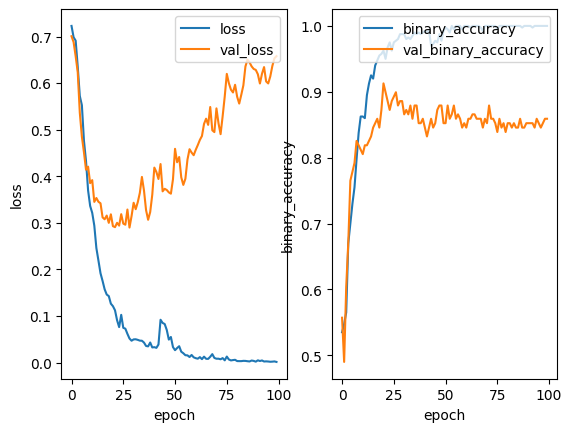

In [80]:
utils.plot_history(history, ('loss', 'binary_accuracy'));

In [81]:
abstractor_model.evaluate(X_train, y_train)

16/16 [==============================] - 0s 1ms/step - loss: 0.1058 - binary_accuracy: 0.9798


[0.10577905923128128, 0.9797979593276978]

In [82]:
abstractor_model.evaluate(X_test, y_test)

11/11 [==============================] - 0s 1ms/step - loss: 0.7301 - binary_accuracy: 0.8592


[0.7301455736160278, 0.8591954112052917]

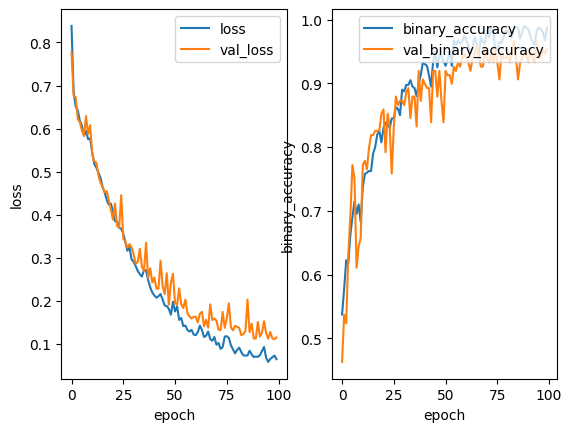

In [85]:
utils.plot_history(history, ('loss', 'binary_accuracy'));

In [86]:
transformer_model.evaluate(X_train, y_train)
transformer_model.evaluate(X_test, y_test)

11/11 [==============================] - 0s 981us/step - loss: 0.1696 - binary_accuracy: 0.9368


[0.16956239938735962, 0.9367815852165222]

## CorelNet

In [37]:
from multi_head_relation import MultiHeadRelation
from tensorflow.keras import layers

In [38]:
embedding_dim = 64
ordercorelnet_kwargs = dict(embedding_dim=embedding_dim)

class CorelNetRMTSModel(tf.keras.Model):
    def __init__(self, embedding_dim, name=None):
        super().__init__(name=name)
        self.embedder = layers.Dense(embedding_dim)
        self.flatten = layers.Flatten()
        self.hidden_dense = layers.Dense(32, activation='relu', name='hidden_layer')
        self.final_layer = layers.Dense(1, activation='sigmoid', name='final_layer')
    
    def call(self, inputs):
        x = self.embedder(inputs)
        x = tf.matmul(x, x, transpose_b=True)
        x = self.flatten(x)
        x = self.hidden_dense(x)
        x = self.final_layer(x)

        return x

    def print_summary(self, input_shape):
        inputs = layers.Input(input_shape)
        outputs = self.call(inputs)
        print(tf.keras.Model(inputs, outputs).summary())

corelnet_model = CorelNetRMTSModel(**ordercorelnet_kwargs, name='order_corelnet')
corelnet_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
corelnet_model(X_train[:32]);
corelnet_model.print_summary(X.shape[1:]);

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 2, 64)]              0         []                            
                                                                                                  
 dense_214 (Dense)           (None, 2, 64)                4160      ['input_7[0][0]']             
                                                                                                  
 tf.linalg.matmul (TFOpLamb  (None, 2, 2)                 0         ['dense_214[0][0]',           
 da)                                                                 'dense_214[0][0]']           
                                                                                                  
 flatten_265 (Flatten)       (None, 4)                    0         ['tf.linalg.matmul[0][0]']

In [39]:
Total_hdc = []
for train_size in [10,50,75,100,150,175,200]:
    hdc = []
    for _ in range(10):
        create_opt = lambda : tf.keras.optimizers.Adam(learning_rate=0.0001)
        transformer_model = CorelNetRMTSModel(**ordercorelnet_kwargs, name='order_corelnet')
        transformer_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
        X_train_1, y_train_1 = X_train[:train_size], y_train[:train_size]
        history = transformer_model.fit(X_train_1, y_train_1, validation_data=(X_val, y_val), epochs=50, batch_size=64,verbose=0)
        acc = transformer_model.evaluate(X_test, y_test,verbose=0)[1]
        hdc.append(acc)
    hdc = np.array(hdc)
    Total_hdc.append(hdc)
np.save('total_corelnet.npy',Total_hdc)

In [40]:
embedding_dim = 64
ordercorelnet_kwargs = dict(embedding_dim=embedding_dim)

class MLPRMTSModel(tf.keras.Model):
    def __init__(self, embedding_dim, name=None):
        super().__init__(name=name)
        self.embedder = layers.Dense(embedding_dim)
        self.flatten = layers.Flatten()
        self.hidden_dense = layers.Dense(32, activation='relu', name='hidden_layer')
        self.final_layer = layers.Dense(1, activation='sigmoid', name='final_layer')
    
    def call(self, inputs):
        x = self.embedder(inputs)
        x = self.flatten(x)
        x = self.hidden_dense(x)
        x = self.final_layer(x)

        return x

    def print_summary(self, input_shape):
        inputs = layers.Input(input_shape)
        outputs = self.call(inputs)
        print(tf.keras.Model(inputs, outputs).summary())

corelnet_model = MLPRMTSModel(**ordercorelnet_kwargs, name='order_corelnet')
corelnet_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
corelnet_model(X_train[:32]);
corelnet_model.print_summary(X.shape[1:]);

Total_hdc = []
for train_size in [10,50,75,100,150,175,200]:
    hdc = []
    for _ in range(10):
        create_opt = lambda : tf.keras.optimizers.Adam(learning_rate=0.0001)
        transformer_model = MLPRMTSModel(**ordercorelnet_kwargs, name='order_corelnet')
        transformer_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
        X_train_1, y_train_1 = X_train[:train_size], y_train[:train_size]
        history = transformer_model.fit(X_train_1, y_train_1, validation_data=(X_val, y_val), epochs=50, batch_size=64,verbose=0)
        acc = transformer_model.evaluate(X_test, y_test,verbose=0)[1]
        hdc.append(acc)
    hdc = np.array(hdc)
    Total_hdc.append(hdc)
np.save('total_mlp.npy',Total_hdc)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 2, 64)]           0         
                                                                 
 dense_285 (Dense)           (None, 2, 64)             4160      
                                                                 
 flatten_336 (Flatten)       (None, 128)               0         
                                                                 
 hidden_layer (Dense)        (None, 32)                4128      
                                                                 
 final_layer (Dense)         (None, 1)                 33        
                                                                 
Total params: 8321 (32.50 KB)
Trainable params: 8321 (32.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


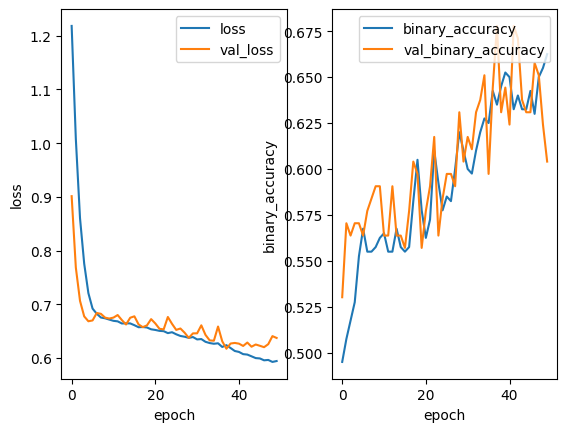

In [18]:
utils.plot_history(history, ('loss', 'binary_accuracy'));

In [19]:
corelnet_model.evaluate(X_train, y_train)

16/16 [==============================] - 0s 773us/step - loss: 0.6083 - binary_accuracy: 0.6384


[0.6082603931427002, 0.6383838653564453]

In [20]:
corelnet_model.evaluate(X_test, y_test)

11/11 [==============================] - 0s 961us/step - loss: 0.6590 - binary_accuracy: 0.5805


[0.6589752435684204, 0.5804597735404968]

## Transformer

In [41]:
from transformer_modules import Encoder
from tensorflow.keras import layers

In [42]:
embedding_dim = 64
encoder_kwargs = dict(
    num_layers=1, 
    num_heads=1,
    dff=64,
    dropout_rate=0.1)

ordertransformer_kwargs = dict(embedding_dim=embedding_dim, encoder_kwargs=encoder_kwargs)

class TransformerOrderModel(tf.keras.Model):
    def __init__(self, embedding_dim, encoder_kwargs, name=None):
        super().__init__(name=name)
        self.embedder = layers.Dense(embedding_dim)
        self.encoder = Encoder(**encoder_kwargs)
        self.flatten = layers.Flatten()
        self.hidden_dense = layers.Dense(32, activation='relu', name='hidden_layer')
        self.final_layer = layers.Dense(1, activation='sigmoid', name='final_layer')
    
    def call(self, inputs):
        x = self.embedder(inputs)
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.hidden_dense(x)
        x = self.final_layer(x)

        return x

    def print_summary(self, input_shape):
        inputs = layers.Input(input_shape)
        outputs = self.call(inputs)
        print(tf.keras.Model(inputs, outputs, name=self.name).summary())


transformer_model = TransformerOrderModel(**ordertransformer_kwargs, name='rmts_transformer')
transformer_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
transformer_model(X_train[:32])
transformer_model.print_summary(X.shape[1:])

Model: "rmts_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 2, 64)]           0         
                                                                 
 dense_356 (Dense)           (None, 2, 64)             4160      
                                                                 
 encoder (Encoder)           (None, 2, 64)             25216     
                                                                 
 flatten_407 (Flatten)       (None, 128)               0         
                                                                 
 hidden_layer (Dense)        (None, 32)                4128      
                                                                 
 final_layer (Dense)         (None, 1)                 33        
                                                                 
Total params: 33537 (131.00 KB)
Trainable params: 

In [43]:
Total_hdc = []
for train_size in [10,50,75,100,150,175,200]:
    hdc = []
    for _ in range(10):
        create_opt = lambda : tf.keras.optimizers.Adam(learning_rate=0.0001)
        transformer_model = TransformerOrderModel(**ordertransformer_kwargs, name='rmts_transformer')
        transformer_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
        X_train_1, y_train_1 = X_train[:train_size], y_train[:train_size]
        history = transformer_model.fit(X_train_1, y_train_1, validation_data=(X_val, y_val), epochs=50, batch_size=64,verbose=0)
        acc = transformer_model.evaluate(X_test, y_test,verbose=0)[1]
        hdc.append(acc)
    hdc = np.array(hdc)
    Total_hdc.append(hdc)
np.save('total_transformer.npy',Total_hdc)

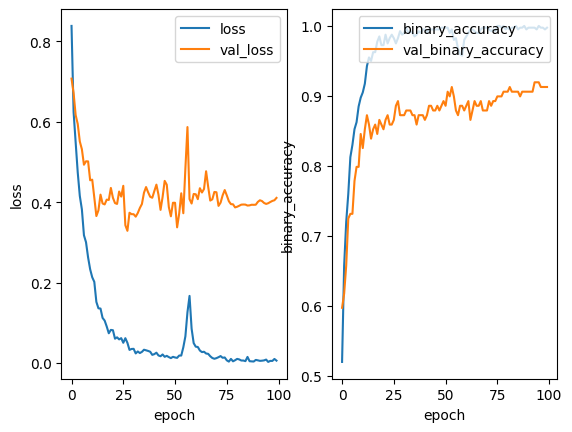

In [26]:
transformer_model.evaluate(X_test, y_test)

11/11 [==============================] - 0s 1ms/step - loss: 0.3079 - binary_accuracy: 0.8764


[0.3078586459159851, 0.8764367699623108]

## Learning curve evaluation

In [48]:
## Pruning